In [ ]:
#Supplementary computer code accompanying Hoyal Cuthill, Guttenberg, Ledger, Crowther and Huertas (2019) 
#Deep learning on butterfly phenotypes tests evolution’s oldest mathematical model. Science Advances. 
#Please cite this paper in reference to this code.

In [ ]:
# NUM_LABELS = 27
NUM_LABELS = 24
# NUM_LABELS = 2

In [ ]:
%pylab inline

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import glob
import sys

from math import *

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import copy

from PIL import Image

from IPython import display
import time

import pickle

import scipy.cluster.hierarchy as sch

def tovar(x):
    return Variable(torch.FloatTensor(x).cuda(), requires_grad = False)

def toivar(x):
    return Variable(torch.LongTensor(x).cuda(), requires_grad = False)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
class Embed(nn.Module):
    def __init__(self):
        super(Embed,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,9,padding=4)
        torch.nn.init.orthogonal(self.conv1.weight)

        self.p1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32,96,3,padding=1)
        torch.nn.init.orthogonal(self.conv2.weight)
        self.conv2b = nn.Conv2d(96,48,1)
        torch.nn.init.orthogonal(self.conv2b.weight)
        self.p2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(48,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv3.weight)
        self.conv3b = nn.Conv2d(128,64,1)
        torch.nn.init.orthogonal(self.conv3b.weight)        
        self.p3 = nn.MaxPool2d(2)
        
        self.conv4 = nn.Conv2d(64,96,3,padding=1)
        torch.nn.init.orthogonal(self.conv4.weight)        
        self.p4 = nn.MaxPool2d(2)
        
        self.conv5 = nn.Conv2d(96,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv5.weight)        
        self.conv6 = nn.Conv2d(128,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv6.weight)        
        self.p5 = nn.MaxPool2d(2)
        
        self.dense1 = nn.Linear(10*128,256)
        self.dense2 = nn.Linear(256,256)
        self.dense3 = nn.Linear(256,64)
        
    def inter(self, x):
        z = self.p1(F.elu(self.conv1(x)))
        #z = self.p2(F.elu(self.conv2b(F.elu(self.conv2(z)))))
        #z = self.p3(F.elu(self.conv3b(F.elu(self.conv3(z)))))
        #z = self.p4(F.elu(self.conv4(z)))
        
        #z = F.elu(self.conv5(z))
        #z = z + F.elu(self.conv6(z))
        
        return z

    def forward(self, x):
        z = self.p1(F.elu(self.conv1(x)))
        z = self.p2(F.elu(self.conv2b(F.elu(self.conv2(z)))))
        z = self.p3(F.elu(self.conv3b(F.elu(self.conv3(z)))))
        z = self.p4(F.elu(self.conv4(z)))
        
        z = F.elu(self.conv5(z))
        z = z + F.elu(self.conv6(z))
        z = self.p5(z)
        
        s = z.size()
        z = z.permute(0,1,2,3).contiguous().view(s[0],s[1]*s[2]*s[3])
        
        z = F.elu(self.dense1(z))
        z = F.elu(self.dense2(z))
        z = self.dense3(z)
        
        z = z / torch.sqrt(torch.sum(z**2,1,keepdim=True)+1e-16)
        
        return z
        
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.embed = Embed()
        self.dense1 = nn.Linear(64,96)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(96,96)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(96,96)
        self.drop3 = nn.Dropout(0.5)
        self.dense4 = nn.Linear(96,NUM_LABELS)
        
        self.adam = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def get_embedding(self,x):
        return self.embed(x)
    
    def predict(self, z):
        z = self.drop1(F.elu(self.dense1(z)))
        z = self.drop2(F.elu(self.dense2(z)))
        z = self.drop3(F.elu(self.dense3(z)))
        p = F.softmax(self.dense4(z),dim=1)
        
        return p
        
    def forward(self,x1,x2,x3):
        z1 = self.get_embedding(x1)
        z2 = self.get_embedding(x2)
        z3 = self.get_embedding(x3)
        
        p = self.predict(z1)
        
        return p,z1,z2,z3    

    def triplet(self,z1,z2,z3):
        return torch.mean((z1-z2)**2) - torch.mean((z1-z3)**2)
    
    def loss(self,p,z1,z2,z3,y):
        tloss = self.triplet(z1,z2,z3)
        
        p = torch.clamp(p,1e-6,1-1e-6)
        idx = torch.LongTensor(np.arange(p.size()[0])).cuda()        
        loss = torch.mean(-torch.log(p[idx,y[idx]]))
        
        reg = 0
        for param in self.parameters():
            reg = reg + torch.mean(param**2)
            
        loss = loss + 6e-5*reg + 0.1 * tloss
        
        return loss


In [ ]:
LOAD_PRETRAINED = False
net = Net().cuda()

if LOAD_PRETRAINED:
    net.load_state_dict(torch.load("/content/drive/MyDrive/testing.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

In [ ]:
def load_data(dataset, img_idx, label_idx) : 
  data = []
  tlabels = []

  for i in range(dataset.shape[0]):
      im = np.array(Image.open("/content/drive/My Drive/Butterflies_Shared/LowResolution/"+dataset.iloc[i,img_idx])).transpose(2,0,1)
      iarr = np.ones((3,64,160))*240
      x0 = int((160-im.shape[2])/2)
      iarr[:,:,x0:x0+im.shape[2]] = im
      
      data.append((iarr-127.5)/128.0)
      tlabels.append(dataset.iloc[i,label_idx])

  LE = LabelEncoder()
  labels = LE.fit_transform(tlabels)
  data = np.array(data)

  # np.random.seed(12345)
  # idx = np.random.permutation(data.shape[0])
  # data = data[idx]
  # labels = labels[idx]
  # subspecies = np.array(dataset['Subspecies'].tolist())[idx]
  subspecies = np.array(dataset['Subspecies'].tolist())
  return data, labels, subspecies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ordered_dataset = pd.read_csv("/content/drive/MyDrive/Butterflies_Shared/data_ordered.csv")
# ordered_data, ordered_labels, ordered_subspecies = load_data(ordered_dataset, 1, 4) 

In [ ]:
ordered_dataset = pd.read_csv("/content/drive/MyDrive/Butterflies_Shared/data_ordered.csv")

train, test = ordered_dataset.iloc[:1500], ordered_dataset.iloc[1500:]
train = train[train['Hybrid status of additional taxonomic information'] != 'hybrid'].reset_index(drop=True) 
test = test[test['Hybrid status of additional taxonomic information'] != 'hybrid'].reset_index(drop=True) 
test = test[test['Subspecies'] != 'dignus'].reset_index(drop=True)
train = train[train['Subspecies'].isin(comimics_subspecies)].reset_index(drop=True)
test = test[test['Subspecies'].isin(comimics_subspecies)].reset_index(drop=True)
only_comimics = pd.concat([train, test]).reset_index(drop=True)

In [ ]:
test

,NHM specimen number,Image filename,View,Species,Subspecies,Sex,Additional taxonomic information (from specimen labels),Type Status,Hybrid status of additional taxonomic information,Included in reduced dataset,Locality,Locality latitude,Locality longitude
0,10428239,10428239_D_lowres.tif,dorsal,melpomene,aglaope,female,f._aglaope,NaN,subspecies synonym,1,Cauca COL,NaN,NaN
1,10428837,10428837_V_lowres.tif,ventral,erato,hydara,female,f._hydara,NaN,subspecies synonym,1,Caicara de Orinoco VEN BOL,-0.240000,-78.647500
2,10428339,10428339_D_lowres.tif,dorsal,melpomene,thelxiopeia,male,thelxiopeia,NaN,valid subspecies,1,St Laurent du Maroni FRG LM,5.500000,-54.033333
3,10428228,10428228_D_lowres.tif,dorsal,melpomene,aglaope,male,f._aglaope,NaN,subspecies synonym,1,Osayacu ECD NA,-1.583333,-77.750000
4,10428582,10428582_D_lowres.tif,dorsal,erato,phyllis,female,f._diffluens,NaN,subspecies synonym,1,Santa Cruz de la Sierra BOL SC,-17.800000,-63.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,10428894,10428894_D_lowres.tif,dorsal,erato,cyrbia,male,f._cyrbia,NaN,subspecies synonym,1,Babahoyo ECD LR,-1.816667,-79.516667
626,10428146,10428146_V_lowres.tif,ventral,melpomene,plesseni,female,plesseni,NaN,valid subspecies,1,Alpayacu ECD PA,-1.466667,-78.116667
627,10428932,10428932_V_lowres.tif,ventral,erato,microclea,male,f._microclea,NaN,subspecies synonym,1,La Merced PER JU,-11.050000,-75.316667
628,10428374,10428374_D_lowres.tif,dorsal,melpomene,melpomene,male,ab._atrosecta,NaN,subspecies synonym,1,St Jean du Maroni FRG LM,5.400000,-54.083333


In [ ]:
ordered_dataset = ordered_dataset[ordered_dataset['Hybrid status of additional taxonomic information'] != 'hybrid'].reset_index(drop=True) 
ordered_dataset = ordered_dataset[ordered_dataset['Subspecies'].isin(comimics_subspecies)].reset_index(drop=True)
ordered_dataset = ordered_dataset[ordered_dataset['Species'] == 'erato'].reset_index(drop=True)

In [ ]:
mimicry_rings = {}
count = 0
for i in range(len(comimics_table)) : 
  e, m = comimics_table['Erato'][i], comimics_table['Melpomene'][i]
  if e in mimicry_rings : 
    mimicry_rings[m] = mimicry_rings[e] 
  elif m in mimicry_rings : 
    mimicry_rings[e] = mimicry_rings[m] 
  else : 
    mimicry_rings[m] = count 
    mimicry_rings[e] = count  
    count += 1
labels = np.array([mimicry_rings[ss] for ss in ordered_dataset['Subspecies'].tolist()])
ordered_dataset['Label'] = labels
train, test = ordered_dataset.iloc[:590], ordered_dataset.iloc[590:]
only_comimics = pd.concat([train, test]).reset_index(drop=True)

In [ ]:
comimics_table = pd.read_csv('/content/drive/MyDrive/comimics_table.csv')
comimics_table = comimics_table.drop(index=11).reset_index(drop=True)
comimics_subspecies = set(comimics_table['Melpomene'].tolist()).union(set(comimics_table['Erato'].tolist()))
train, test = ordered_dataset.iloc[:1500], ordered_dataset[1500:]
train = train[train['Subspecies'].isin(comimics_subspecies)].reset_index(drop=True)
test = test[test['Subspecies'].isin(comimics_subspecies)].reset_index(drop=True)
train = train[train['Hybrid status of additional taxonomic information']!='hybrid'].reset_index(drop=True)
test = test[test['Hybrid status of additional taxonomic information']!='hybrid'].reset_index(drop=True)
mimicry_rings = {}
count = 0
# train = train[train['Species']=='melpomene']
# test = test[test['Species'] == 'melpomene']
for i in range(len(comimics_table)) : 
  e, m = comimics_table['Erato'][i], comimics_table['Melpomene'][i]
  if e in mimicry_rings : 
    mimicry_rings[m] = mimicry_rings[e] 
  elif m in mimicry_rings : 
    mimicry_rings[e] = mimicry_rings[m] 
  else : 
    mimicry_rings[m] = count 
    mimicry_rings[e] = count  
    count += 1
comimics_labels_train = np.array([mimicry_rings[ss] for ss in train['Subspecies'].tolist()])
train['Label'] = comimics_labels_train
comimics_labels_test = np.array([mimicry_rings[ss] for ss in test['Subspecies'].tolist()])
test['Label'] = comimics_labels_test
only_comimics = pd.concat([train, test]).reset_index(drop=True)

In [ ]:
len(train)

958

In [ ]:
only_comimics

,NHM specimen number,Image filename,View,Species,Subspecies,Sex,Additional taxonomic information (from specimen labels),Type Status,Hybrid status of additional taxonomic information,Included in reduced dataset,Locality,Locality latitude,Locality longitude,Label
0,10429115,10429115_D_lowres.tif,dorsal,erato,lativitta,male,f._lativitta,NaN,subspecies synonym,1,Yungas de La Paz BOL LP,-16.333333,-66.750000,1
1,10428999,10428999_V_lowres.tif,ventral,erato,favorinus,male,favorinus,NaN,valid subspecies,1,Tingo Maria PER HU,-9.300000,-76.000000,3
2,10429127,10429127_D_lowres.tif,dorsal,erato,lativitta,male,f._lativitta,NaN,subspecies synonym,1,San Antonio falls above Rio Madeira BRA RO,-8.866667,-64.050000,1
3,10428066,10428066_D_lowres.tif,dorsal,melpomene,cythera,female,cythera,NaN,valid subspecies,1,Bolivia COUNTRY,NaN,NaN,0
4,10428885,10428885_D_lowres.tif,dorsal,erato,cyrbia,male,f._cyrbia,NaN,subspecies synonym,1,Santo Domingo de los Colorados ECD PI,-1.583333,-77.750000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,10428894,10428894_D_lowres.tif,dorsal,erato,cyrbia,male,f._cyrbia,NaN,subspecies synonym,1,Babahoyo ECD LR,-1.816667,-79.516667,0
1584,10428146,10428146_V_lowres.tif,ventral,melpomene,plesseni,female,plesseni,NaN,valid subspecies,1,Alpayacu ECD PA,-1.466667,-78.116667,8
1585,10428932,10428932_V_lowres.tif,ventral,erato,microclea,male,f._microclea,NaN,subspecies synonym,1,La Merced PER JU,-11.050000,-75.316667,7
1586,10428374,10428374_D_lowres.tif,dorsal,melpomene,melpomene,male,ab._atrosecta,NaN,subspecies synonym,1,St Jean du Maroni FRG LM,5.400000,-54.083333,6


In [ ]:
train, test = ordered_dataset.iloc[:1500], ordered_dataset[1500:]
train = train[train['Hybrid status of additional taxonomic information'] != 'hybrid'].reset_index(drop=True)
test = test[test['Hybrid status of additional taxonomic information'] != 'hybrid'].reset_index(drop=True)
only_comimics = pd.concat([train, test]).reset_index(drop=True)

In [ ]:
len(set(ordered_labels[:TRAIN]))

33

In [ ]:
ordered_data, ordered_labels, ordered_subspecies = load_data(only_comimics, 1, 4) 

In [ ]:
# original_data = pd.read_csv("/content/drive/MyDrive/Butterflies/supplementary_table.csv")
# comimics_table = pd.read_csv('/content/drive/MyDrive/comimics_table.csv')
# comimics_subspecies = set(comimics_table['Melpomene'].tolist()).union(set(comimics_table['Erato'].tolist()))
# only_erato = pd.read_csv("/content/drive/My Drive/Butterflies/erato_data_numbered.csv")
# only_melpomene = pd.read_csv("/content/drive/My Drive/Butterflies/melpomene_data_numbered.csv") 
# all_numbered = pd.read_csv("/content/drive/My Drive/Butterflies/all_data_numbered.csv")
# only_comimics = original_data[original_data['Subspecies'].isin(comimics_subspecies)].reset_index(drop=True)

In [ ]:
only_comimics.to_csv('melpomene.csv')

In [ ]:
NORMAL, NONMIMIC, COMIMIC, SAME = 0, 1, 2, 3
TRIPLET_TYPE = NORMAL

In [ ]:
only_comimics

,NHM specimen number,Image filename,View,Species,Subspecies,Sex,Additional taxonomic information (from specimen labels),Type Status,Hybrid status of additional taxonomic information,Included in reduced dataset,Locality,Locality latitude,Locality longitude,Label
0,10429115,10429115_D_lowres.tif,dorsal,erato,lativitta,male,f._lativitta,NaN,subspecies synonym,1,Yungas de La Paz BOL LP,-16.333333,-66.750000,1
1,10428999,10428999_V_lowres.tif,ventral,erato,favorinus,male,favorinus,NaN,valid subspecies,1,Tingo Maria PER HU,-9.300000,-76.000000,3
2,10429127,10429127_D_lowres.tif,dorsal,erato,lativitta,male,f._lativitta,NaN,subspecies synonym,1,San Antonio falls above Rio Madeira BRA RO,-8.866667,-64.050000,1
3,10428066,10428066_D_lowres.tif,dorsal,melpomene,cythera,female,cythera,NaN,valid subspecies,1,Bolivia COUNTRY,NaN,NaN,0
4,10428885,10428885_D_lowres.tif,dorsal,erato,cyrbia,male,f._cyrbia,NaN,subspecies synonym,1,Santo Domingo de los Colorados ECD PI,-1.583333,-77.750000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,10428894,10428894_D_lowres.tif,dorsal,erato,cyrbia,male,f._cyrbia,NaN,subspecies synonym,1,Babahoyo ECD LR,-1.816667,-79.516667,0
1584,10428146,10428146_V_lowres.tif,ventral,melpomene,plesseni,female,plesseni,NaN,valid subspecies,1,Alpayacu ECD PA,-1.466667,-78.116667,8
1585,10428932,10428932_V_lowres.tif,ventral,erato,microclea,male,f._microclea,NaN,subspecies synonym,1,La Merced PER JU,-11.050000,-75.316667,7
1586,10428374,10428374_D_lowres.tif,dorsal,melpomene,melpomene,male,ab._atrosecta,NaN,subspecies synonym,1,St Jean du Maroni FRG LM,5.400000,-54.083333,6


In [ ]:
comimics_table

,Melpomene,Erato
0,cythera,cyrbia
1,aglaope,lativitta
2,amandus,phyllis
3,amaryllis,favorinus
4,burchelli,phyllis
5,ecuadorensis,etylus
6,thelxiopeia,erato
7,melpomene,hydara
8,xenoclea,microclea
9,nanna,phyllis


In [ ]:
erato_labels

{'amalfreda',
 'amphitrite',
 'colombina',
 'cyrbia',
 'demophoon',
 'dignus',
 'emma',
 'erato',
 'etylus',
 'favorinus',
 'favorinusxlativitta',
 'guarica',
 'hydara',
 'lativitta',
 'luscombei',
 'microclea',
 'notabilis',
 'petiverana',
 'phyllis',
 'venus',
 'venustus'}

In [ ]:
subspecies_dict

{'aglaope': 0,
 'amaryllis': 1,
 'burchelli': 2,
 'cyrbia': 3,
 'cythera': 4,
 'demophoon': 5,
 'ecuadorensis': 6,
 'erato': 7,
 'etylus': 8,
 'favorinus': 9,
 'hydara': 10,
 'lativitta': 11,
 'melpomene': 12,
 'microclea': 13,
 'nanna': 14,
 'notabilis': 15,
 'petiverana': 16,
 'phyllis': 17,
 'plesseni': 18,
 'rosina': 19,
 'thelxiopeia': 20,
 'venus': 21,
 'vulcanus': 22,
 'xenoclea': 23}

In [ ]:
ordered_dataset = only_comimics

In [ ]:
comimics_subspecies = list(set(only_comimics['Subspecies'].tolist()))

In [ ]:
comimics_table = comimics_table.drop(index=2).reset_index(drop=True)

In [ ]:
only_comimics

,NHM specimen number,Image filename,View,Species,Subspecies,Sex,Additional taxonomic information (from specimen labels),Type Status,Hybrid status of additional taxonomic information,Included in reduced dataset,Locality,Locality latitude,Locality longitude
0,10429115,10429115_D_lowres.tif,dorsal,erato,lativitta,male,f._lativitta,NaN,subspecies synonym,1,Yungas de La Paz BOL LP,-16.333333,-66.750000
1,10428999,10428999_V_lowres.tif,ventral,erato,favorinus,male,favorinus,NaN,valid subspecies,1,Tingo Maria PER HU,-9.300000,-76.000000
2,10429127,10429127_D_lowres.tif,dorsal,erato,lativitta,male,f._lativitta,NaN,subspecies synonym,1,San Antonio falls above Rio Madeira BRA RO,-8.866667,-64.050000
3,10428066,10428066_D_lowres.tif,dorsal,melpomene,cythera,female,cythera,NaN,valid subspecies,1,Bolivia COUNTRY,NaN,NaN
4,10428885,10428885_D_lowres.tif,dorsal,erato,cyrbia,male,f._cyrbia,NaN,subspecies synonym,1,Santo Domingo de los Colorados ECD PI,-1.583333,-77.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,10428894,10428894_D_lowres.tif,dorsal,erato,cyrbia,male,f._cyrbia,NaN,subspecies synonym,1,Babahoyo ECD LR,-1.816667,-79.516667
1748,10428146,10428146_V_lowres.tif,ventral,melpomene,plesseni,female,plesseni,NaN,valid subspecies,1,Alpayacu ECD PA,-1.466667,-78.116667
1749,10428932,10428932_V_lowres.tif,ventral,erato,microclea,male,f._microclea,NaN,subspecies synonym,1,La Merced PER JU,-11.050000,-75.316667
1750,10428374,10428374_D_lowres.tif,dorsal,melpomene,melpomene,male,ab._atrosecta,NaN,subspecies synonym,1,St Jean du Maroni FRG LM,5.400000,-54.083333


In [ ]:
if TRIPLET_TYPE == SAME : 
  erato_labels = {only_comimics['Subspecies'][i] for i in range(len(only_comimics)) if only_comimics['Species'][i] == 'erato'}
  melpomene_labels = {only_comimics['Subspecies'][i] for i in range(len(only_comimics)) if only_comimics['Species'][i] == 'melpomene'}
  subspecies_dict = {ordered_subspecies[i] : ordered_labels[i] for i in range(len(ordered_data))}
  erato_labels = {subspecies_dict[ss] for ss in erato_labels} 
  melpomene_labels = {subspecies_dict[ss] for ss in melpomene_labels} 
elif TRIPLET_TYPE != NORMAL : 
  subspecies_dict = {ordered_subspecies[i] : ordered_labels[i] for i in range(len(ordered_data))}
  labels_dict = {subspecies_dict[ss] : [] for ss in comimics_subspecies}
  for i in range(len(comimics_table)) : 
    m, e = comimics_table['Melpomene'][i], comimics_table['Erato'][i]
    if m in subspecies_dict and e in subspecies_dict : 
      m, e = subspecies_dict[m], subspecies_dict[e]
      labels_dict[m].append(e)
      labels_dict[e].append(m)
  erato_labels = [subspecies_dict[ss] for ss in comimics_table['Erato'].tolist()]
  melpomene_labels = [subspecies_dict[ss] for ss in comimics_table['Melpomene'].tolist()]

In [ ]:
len(set(ordered_labels))

34

In [ ]:
len(train)

958

In [ ]:
1756*0.6

1053.6

In [ ]:
TRAIN = len(train)

def getTriplet(li):
    i = np.random.randint(TRAIN)
    j = np.random.randint(TRAIN)
    k = np.random.randint(TRAIN)
    
    while (ordered_labels[i]!=li):
        i = np.random.randint(TRAIN)
        
    while (ordered_labels[i]!=ordered_labels[j]):
        j = np.random.randint(TRAIN)

    if TRIPLET_TYPE == NORMAL : 
      while (ordered_labels[i]==ordered_labels[k]):
          k = np.random.randint(TRAIN)
    
    elif TRIPLET_TYPE == COMIMIC : 
      comimics = labels_dict[li]
      while (ordered_labels[k] not in comimics):
          k = np.random.randint(TRAIN)
    
    elif TRIPLET_TYPE == NONMIMIC : 
      comimics = labels_dict[li]
      if li in erato_labels :
        while True:
            k = np.random.randint(TRAIN)
            if ordered_labels[k] in melpomene_labels and ordered_labels[k] not in comimics : 
              break
      
      if li in melpomene_labels : 
        while True : 
          k = np.random.randint(TRAIN)
          if ordered_labels[k] in erato_labels and ordered_labels[k] not in comimics : 
            break
    
    elif TRIPLET_TYPE == SAME : 
      if li in erato_labels : 
        while True : 
          k = np.random.randint(TRAIN) 
          if ordered_labels[k] in erato_labels and ordered_labels[k] != ordered_labels[i]: 
            break
      elif li in melpomene_labels : 
        while True : 
          k = np.random.randint(TRAIN) 
          if ordered_labels[k] in melpomene_labels and ordered_labels[k] != ordered_labels[i]: 
            break
    return i,j,k

def getBatch(N):
    batch1 = []
    batch2 = []
    batch3 = []
    l = []
    
    for i in range(N):
        i1,i2,i3 = getTriplet(i%NUM_LABELS)
        l.append(i%NUM_LABELS)
        batch1.append(np.roll(np.roll(ordered_data[i1],np.random.randint(7)-3,axis=1), np.random.randint(7)-3,axis=2))
        batch2.append(np.roll(np.roll(ordered_data[i2],np.random.randint(7)-3,axis=1), np.random.randint(7)-3,axis=2))
        batch3.append(np.roll(np.roll(ordered_data[i3],np.random.randint(7)-3,axis=1), np.random.randint(7)-3,axis=2))
    
    return np.array(batch1),np.array(batch2),np.array(batch3),np.array(l)

## Training the network

Set TRAIN_NET to True and run. Embeddings will not be identical due to random initialization.

In [ ]:
TRAIN_NET = True

In [ ]:
len(ordered_labels)

606

In [ ]:
only_comimics.to_csv('erato.csv')

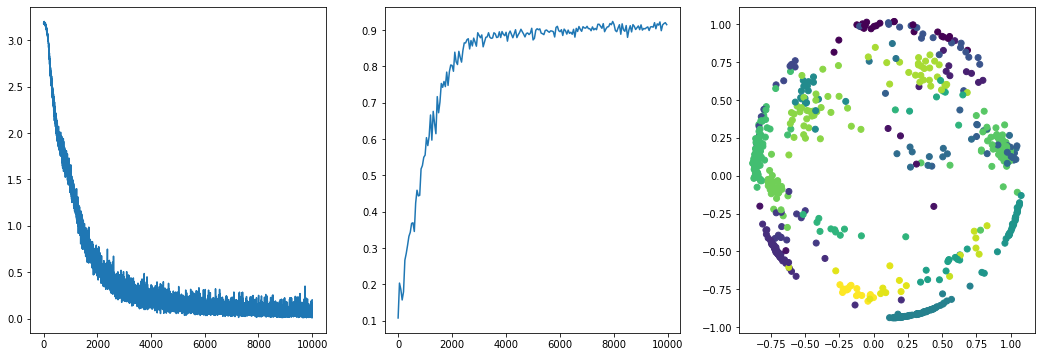

loss:  0.2033466
accuracies:  {'lativitta': 1.0, 'favorinus': 0.6666666666666666, 'cythera': 1.0, 'cyrbia': 0.9423076923076923, 'plesseni': 1.0, 'melpomene': 0.9696969696969697, 'vulcanus': 1.0, 'hydara': 0.9848484848484849, 'microclea': 1.0, 'xenoclea': 1.0, 'petiverana': 0.94, 'phyllis': 0.9315068493150684, 'amaryllis': 0.6666666666666666, 'rosina': 1.0, 'erato': 0.7391304347826086, 'thelxiopeia': 1.0, 'aglaope': 0.7307692307692307, 'notabilis': 0.8461538461538461, 'demophoon': 0.7272727272727273, 'burchelli': 0.6, 'nanna': 1.0, 'ecuadorensis': 0.5, 'venus': 0.875, 'etylus': 0.7692307692307693}


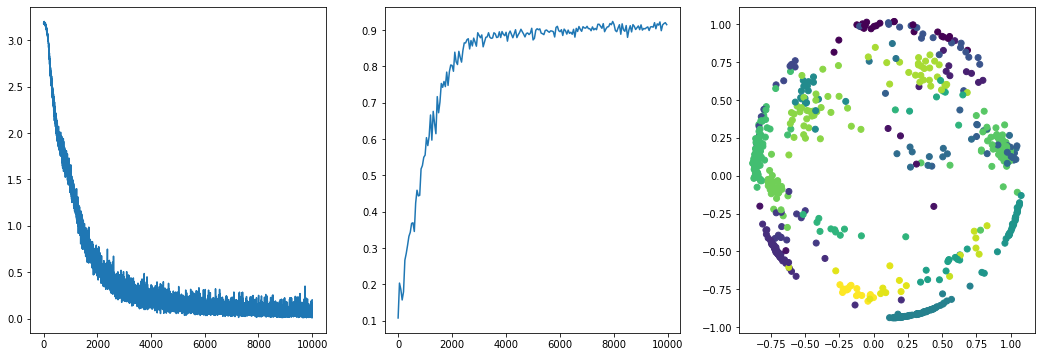

In [ ]:
if TRAIN_NET:
    tr_err = []
    ts_acc = []
    pca = PCA()
    
    for batch in range(10000):
        b1,b2,b3,l = getBatch(NUM_LABELS*3)

        net.train()
        net.zero_grad()

        l = torch.LongTensor(l).cuda()
        p,z1,z2,z3 = net.forward(tovar(b1),tovar(b2),tovar(b3))

        loss = net.loss(p,z1,z2,z3,l)

        tr_err.append(loss.cpu().data.numpy())
        loss.backward()

        net.adam.step()

        net.eval()

        if batch%50 == 49:
            test_embs = []
            test_labels_list = []
            acc = 0
            count = 0
            accs = {ss : 0 for ss in ordered_subspecies} 
            counts = {ss : 0 for ss in ordered_subspecies}
            # for i in range(0, test_data.shape[0], 50) : 
            #     if i + 50 > test_data.shape[0] : 
            #       batch = tovar(test_data[i:])
            #       l = test_labels[i:]
            #       names = test_subspecies[i:]
            #     else : 
            #       batch = tovar(test_data[i:i+50])
            #       l = test_labels[i:i+50]
            #       names = test_subspecies[i:i+50]

            for i in range((ordered_data.shape[0]-TRAIN)//50):
                first = i*50+TRAIN
                last = i*50+TRAIN+50
                if len(ordered_data) - last < 50 : 
                  last = len(ordered_data)
                batch = tovar(ordered_data[first:last])
                l = ordered_labels[first:last]
                names = ordered_subspecies[first:last]
                for l0 in l:
                    test_labels_list.append(l0)

                z = net.get_embedding(batch)                
                p = net.predict(z).cpu().data.numpy()

                z = z.cpu().data.numpy()
                for zm in z:
                    test_embs.append(zm.copy())
                acc += np.mean(np.argmax(p,axis=1)==l)
                count += 1
                truths = np.argmax(p,axis=1)==l
                for i in range(len(truths)) : 
                  counts[names[i]] += 1
                  if truths[i] : 
                    accs[names[i]] += 1

            all_accs = {ss : (accs[ss]/counts[ss]) for ss in accs}
            print('all_accs: ', all_accs)
            
            test_embs = np.array(test_embs)
            test_labels_list = np.array(test_labels_list)
            print("test labels: ", test_labels_list)
            
            pembs = pca.fit_transform(test_embs)
            
            ts_acc.append(acc/float(count))

            plt.clf()
            plt.subplot(1,3,1)
            plt.plot(tr_err)

            plt.subplot(1,3,2)
            plt.plot(np.arange(len(ts_acc))*50,ts_acc)
            
            plt.subplot(1,3,3)
            plt.scatter(pembs[:,0],pembs[:,1],c=test_labels_list)
            
            plt.gcf().set_size_inches((18,6))
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.01)
            torch.save(net.state_dict(), open("on_erato.pth","wb"))
    print("loss: ", loss.cpu().data.numpy())
    print('accuracies: ', all_accs)

In [ ]:
acc/count

0.915

In [ ]:
all_accs

{'aglaope': 0.7307692307692307,
 'amaryllis': 0.6666666666666666,
 'burchelli': 0.6,
 'cyrbia': 0.9423076923076923,
 'cythera': 1.0,
 'demophoon': 0.7272727272727273,
 'ecuadorensis': 0.5,
 'erato': 0.7391304347826086,
 'etylus': 0.7692307692307693,
 'favorinus': 0.6666666666666666,
 'hydara': 0.9848484848484849,
 'lativitta': 1.0,
 'melpomene': 0.9696969696969697,
 'microclea': 1.0,
 'nanna': 1.0,
 'notabilis': 0.8461538461538461,
 'petiverana': 0.94,
 'phyllis': 0.9315068493150684,
 'plesseni': 1.0,
 'rosina': 1.0,
 'thelxiopeia': 1.0,
 'venus': 0.875,
 'vulcanus': 1.0,
 'xenoclea': 1.0}

In [ ]:
accuracies = pd.read_csv('/content/drive/My Drive/Butterflies/accuracies.csv')

In [ ]:
accuracies

,Model,lativitta,favorinus,notabilis,erato,cythera,cyrbia,plesseni,melpomene,vulcanus,hydara,microclea,dignus,xenoclea,petiverana,malleti,phyllis,emma,amandus,amalfreda,amaryllis,colombina,rosina,luscombei,thelxiopeia,aglaope,schunkei,demophoon,burchelli,nanna,ecuadorensis,venustus,venus,amphitrite,etylus,guarica,favorinusxlativitta,flagrans
0,Normal,0.580645,0.75,0.689655,0.861111,0.785714,0.921875,0.976744,0.941176,0.571429,0.928571,1.000000,0.285714,0.956522,0.959184,0.700000,0.940594,0.466667,0.500,0.789474,0.625,1.0,0.941176,0.857143,0.964286,0.806452,0.500000,0.909091,0.9,0.833333,0.666667,0.727273,0.875,0.125000,0.888889,0.25,0.666667,0.0
1,Nonmimic,0.709677,0.50,0.724138,0.945946,0.965517,0.969231,1.000000,0.867925,0.860465,0.846939,0.923077,NaN,1.000000,0.970000,NaN,0.931373,NaN,0.625,NaN,0.625,NaN,0.942857,NaN,1.000000,0.870968,NaN,0.545455,0.5,0.833333,0.833333,NaN,0.875,NaN,0.888889,NaN,NaN,NaN
2,Comimic,0.741935,0.75,0.827586,0.945946,0.827586,0.969231,0.954545,0.924528,0.767442,0.928571,1.000000,NaN,1.000000,0.970000,NaN,0.901961,NaN,0.875,NaN,0.625,NaN,0.971429,NaN,1.000000,0.741935,NaN,0.272727,0.6,1.000000,0.611111,NaN,0.750,NaN,0.944444,NaN,NaN,NaN
3,Same,0.387097,0.75,0.827586,0.918919,0.965517,0.984615,0.977273,0.849057,0.697674,0.928571,1.000000,0.285714,1.000000,0.960000,0.636364,0.872549,0.666667,0.625,0.684211,0.625,1.0,0.942857,0.500000,1.000000,0.645161,0.608696,0.636364,0.6,0.833333,0.722222,0.545455,0.875,0.000000,0.833333,0.25,1.000000,0.5
4,Comimic2,0.741935,1.00,0.793103,1.000000,0.965517,0.953846,1.000000,0.962264,0.813953,0.969388,1.000000,NaN,0.956522,0.980000,NaN,0.960784,NaN,0.750,NaN,0.625,NaN,1.000000,NaN,1.000000,0.903226,NaN,0.636364,0.9,1.000000,0.722222,NaN,0.750,NaN,1.000000,NaN,NaN,NaN
5,Only_comimics,0.774194,0.75,0.827586,0.972973,1.000000,1.000000,0.977273,0.924528,0.697674,0.979592,1.000000,NaN,1.000000,0.970000,NaN,0.970588,NaN,0.750,NaN,0.625,NaN,0.885714,NaN,1.000000,0.903226,NaN,0.909091,0.9,1.000000,0.722222,NaN,0.875,NaN,0.944444,NaN,NaN,NaN
6,Erato,0.806452,0.50,0.724138,1.000000,NaN,0.938462,NaN,NaN,NaN,0.989796,1.000000,NaN,NaN,1.000000,NaN,0.980392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.875,NaN,0.944444,NaN,NaN,NaN
7,Melpomene,NaN,NaN,NaN,NaN,0.965517,NaN,1.000000,0.924528,0.953488,NaN,NaN,NaN,0.956522,NaN,NaN,NaN,NaN,1.000,NaN,0.625,NaN,1.000000,NaN,1.000000,0.774194,NaN,NaN,0.9,1.000000,0.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Mimicry_labels,0.741935,1.00,0.827586,0.945946,0.965517,0.953846,1.000000,0.886792,0.883721,0.948980,1.000000,NaN,1.000000,1.000000,NaN,0.990196,NaN,0.875,NaN,0.625,NaN,1.000000,NaN,0.964286,0.838710,NaN,1.000000,0.9,1.000000,0.777778,NaN,0.750,NaN,0.944444,NaN,NaN,NaN
9,Hard_negatives,0.548387,0.00,0.655172,0.837838,0.689655,0.923077,1.000000,0.754717,0.627907,0.918367,1.000000,0.285714,1.000000,0.970000,0.636364,0.803922,0.266667,0.750,0.842105,0.625,0.0,0.971429,0.750000,0.928571,0.741935,0.434783,0.636364,0.5,0.833333,0.611111,0.454545,0.875,0.555556,0.944444,0.00,0.000000,0.0
